In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from base.tools import convert_nib
from scipy.spatial.distance import dice
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.metrics import jaccard_similarity_score
from nilearn.image import resample_img
from nilearn import plotting as niplt
from neurosynth.base.dataset import Dataset


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
craddock100 = nib.load('../masks/craddock/scorr_05_2level/100.nii.gz')

In [3]:
craddock60 = nib.load('../masks/craddock/scorr_05_2level/60.nii.gz')

###Load data

In [7]:
dataset = Dataset.load('../data/0.6/datasets/db_v6_topics-100.pkl')
ns100 = convert_nib(nib.load('../masks/neurosynth/whole_brain_k_means/whole_brain_kmeans_k100/cluster_labels.nii.gz'))
craddock100 = nib.load('../masks/craddock/scorr_05_2level/100.nii.gz')

In [9]:
craddock100 = resample_img(craddock100, target_affine=ns100.get_affine(), 
                                target_shape=ns100.get_data().shape, interpolation='nearest')

### Match clusters

In [80]:
from base.compare import match_parcellations, get_common_voxels

In [15]:
craddock_ns_distances, ix, conv = match_parcellations(craddock100, ns100)

In [16]:
craddock_ns_distances = 1- craddock_ns_distances

In [17]:
np.apply_along_axis(np.max, 0, craddock_ns_distances).mean()

0.40390435885663833

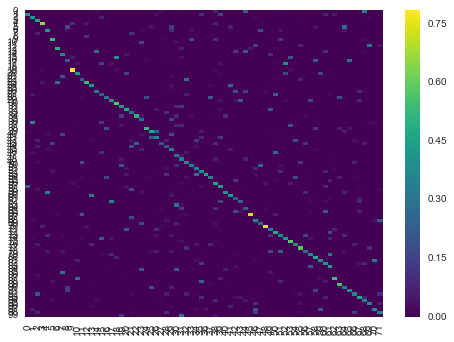

In [18]:
sns.heatmap(craddock_ns_distances, cmap=plt.get_cmap('viridis'))

### Compare similarity using mutual information

In [117]:
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
adjusted_mutual_info_score(craddock100.get_data().flatten(), conv.get_data().flatten())

nan

In [32]:
cd100_data = craddock100.get_data().flatten()
cd_100_nz = cd100_data[cd100_data.nonzero()]
ns_nz = conv.get_data().flatten()[cd100_data.nonzero()]

In [36]:
cd_100_nz.shape

(147072,)

In [43]:
len(conv.get_data().flatten().nonzero()[0])

130389

In [34]:
adjusted_mutual_info_score(cd_100_nz, ns_nz)

0.52538976506669355

### Match Craddock to NS (across n regions)

In [42]:
from base.plotting import find_roi

In [43]:
similarities = []
for n_clusters in range(10, 110, 10):
    ns = convert_nib(nib.load('../results/clustering/matched/craddock/cluster_labels_k%d.nii.gz' % n_clusters))
    
    craddock = nib.load('../masks/craddock/scorr_05_2level/%d.nii.gz' % n_clusters)
    craddock = resample_img(craddock, target_affine=ns.get_affine(), 
                                target_shape=ns.get_data().shape, interpolation='nearest')
    
    cd_ns_distances, ix, nib_conv = match_parcellations(ns, craddock)
    similarities.append(np.apply_along_axis(np.max, 0, 1 - cd_ns_distances).mean())

KeyboardInterrupt: 

In [ ]:
cd_ns_distances, ix, nib_conv = match_parcellations(ns, craddock)

In [ ]:
np.apply_along_axis(np.max, 0, 1 - cd_ns_distances).mean()

In [92]:
similarities

[0.47254570899669829,
 0.46869482995531647,
 0.45757024922203832,
 0.46406632326312014,
 0.47182535059666042,
 0.47953924361348749,
 0.50390581543611956,
 0.48947018021077687,
 0.48847310513461484,
 0.49081939321823037]

### Match AAL

In [47]:
aal_mask = nib.load('../masks/old/Andy/aal_MNI_V4.nii')

In [48]:
data = aal_mask.get_data()

In [49]:
n_regions = np.unique(np.round(data)).nonzero()[0].shape[0]

In [50]:
data[data < 0] = 0
data[data > 0] = 1

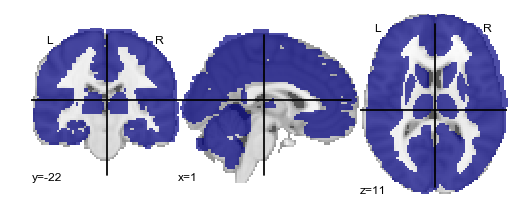

In [51]:
niplt.plot_roi(aal_mask)

In [52]:
aal = nib.load('../masks/old/Andy/aal_MNI_V4.nii')

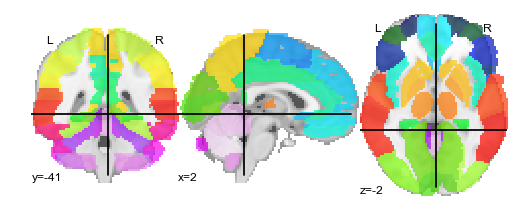

In [53]:
niplt.plot_roi(aal)

In [54]:
ns_aal = convert_nib(nib.load('../results/clustering/matched/aal/cluster_labels_k116.nii.gz'))

In [55]:
separate_unique(ns_aal.get_data().flatten()).sum(axis=1)

array([ 807, 1456, 1478,  969,  562,  564, 1983, 1102, 1163, 1433, 1387,
       1022, 6066, 3873,  966, 2880,  986, 1390, 1306, 1923,  971, 1141,
        530, 2071, 2287,  952, 1895,  606, 5053, 1682, 1457, 1246,  691,
       5194, 4761,  891,  889, 1204, 2001, 1459,  852, 5137, 1468, 1139,
        422, 1783, 1120, 1678,  934,  986, 8426,  873,  793, 1310, 1002,
       1012,  373,  802, 2096,  462,  999,  707, 1458, 1036,  951, 2899,
       1051, 1284, 1066,  927, 1113,  739, 1424, 1966,  297,  732, 1085,
        566,  722, 1273, 1416,  898, 1604,  776,  797,  600, 1678, 1312,
       1270, 2765, 1275, 1135,  755,  721, 2394,  590, 1270,  429,  518,
        730,  264, 2416, 2980, 1060, 5537, 1200, 2770, 1113, 3150,  789,
        353,  670, 1755, 1254,  591,  421])

In [56]:
np.where(separate_unique(aal.get_data().flatten()).sum(axis=1) == separate_unique(aal.get_data().flatten()).sum(axis=1).min())

(array([108]),)

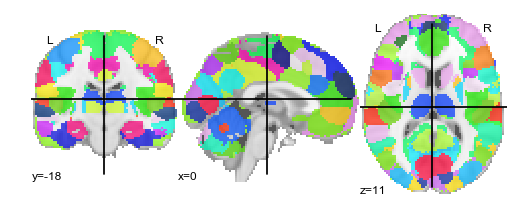

In [57]:
niplt.plot_roi(ns_aal)

In [59]:
ns_all_dist, ix, ns_all_conv = match_parcellations(aal, ns_aal)

In [65]:
adjusted_mutual_info_score(*get_common_voxels(aal, ns_all_conv))

0.548399836928397

In [66]:
ns_all_dist = 1 - ns_all_dist

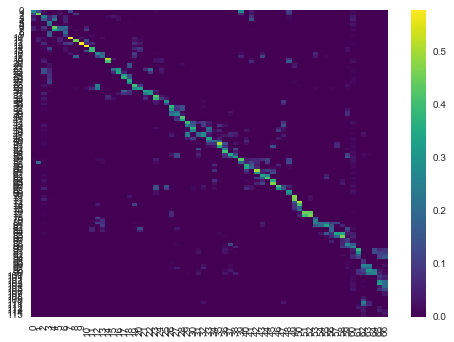

In [67]:
sns.heatmap(ns_all_dist, cmap=plt.get_cmap('viridis'))

In [69]:
np.apply_along_axis(np.max, 0, ns_all_dist).mean()

0.34475747514225696

### MFC - Neubert

In [70]:
neubert = convert_nib(nib.load('../masks/mars/NeubertCingulateOrbitoFrontalParcellation/NeubertCingulateOrbitoFrontalParcellation/CingulateOrbitoFrontal_thr25_2mm_3d.nii.gz'))
neubert_data = neubert.get_data()
neubert_data[neubert_data > 42] = 0
## Match left to right
neubert_data[neubert_data > 21] -= 21

In [72]:
labels =[(0,  "8m") , (1 , "9m") , (2, "11m") , (3,  "14m") , (4,  "23ab") , (5,  "32d") , (6,  "32pl") , (7,  "47m") , (8,  "47o") , (9,  "11") , (10,  "13") , (11,  "24") , (12,  "25") , (13,  "CCZ") , (14,  "FPl") , (15,  "FPm") , (16,  "M1") , (17, "Pre-SMA") , (18,  "RCZa") , (19,  "RCZp") , (20,  "SMA")]
neubert_dict = {v: k + 1 for k, v in dict(labels).items()} 
_, neubert_labels = zip(*labels)
neubert_labels = list(neubert_labels)

In [73]:
remove = ["FPl", "47m", "47o", "11", "13"]
for label in remove:
    neubert_data[neubert_data == neubert_dict[label]] = 0
    neubert_labels.remove(label)

In [75]:
## Unique value counts - max val is 42
zip(range(0, np.bincount(neubert.get_data().flatten()).shape[0]+1), np.bincount(neubert.get_data().flatten()))
ns_MFC = nib.load('../results/clustering/results/MFC/MF/kmeans_k9/cluster_labels.nii.gz')

In [76]:
## New regions
reg_num = [6, 3, 9, 5, 1, 7, 2, 4, 8]
label_names = ['SMAc', 'SMAr',  'pSMAc','pSMAr', 'dACCc', 'dACCr', 'dmPFC' , 'rACC', 'vmPFC']

In [182]:
## New regions
reg_num = [6, 3, 9, 5, 1, 7, 2, 4, 8]
label_names = ['SMAc', 'SMAr',  'pSMAc','pSMAr', 'dACCc', 'dACCr', 'dmPFC' , 'rACC', 'vmPFC']
distances = pairwise_unique(neubert.get_data().flatten(), ns_MFC.get_data().flatten())

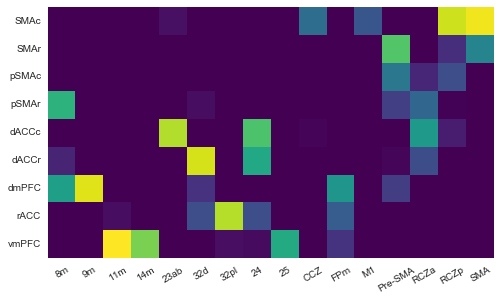

In [78]:
## New regions
reg_num = [6, 3, 9, 5, 1, 7, 2, 4, 8]
label_names = ['SMAc', 'SMAr',  'pSMAc','pSMAr', 'dACCc', 'dACCr', 'dmPFC' , 'rACC', 'vmPFC']
distances = pairwise_unique(neubert.get_data().flatten(), ns_MFC.get_data().flatten())
g = sns.heatmap((1 -distances[:, np.array(reg_num) - 1]).T, xticklabels = neubert_labels, yticklabels = label_names, 
               square=True, cmap=plt.get_cmap('viridis'), cbar=False)
g.set_xticklabels(neubert_labels, rotation=30)

In [183]:
distances = pd.DataFrame((1 - distances[:, np.array(reg_num) - 1]).T, columns=neubert_labels, index=label_names)

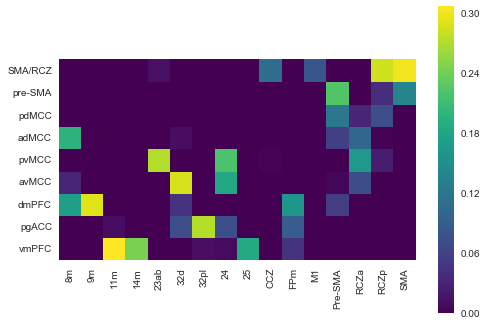

In [184]:
sns.heatmap(distances,square=True, cmap=plt.get_cmap('viridis'))

In [151]:
tx = 

In [159]:
list(reversed([str(tx.get_text()) for tx in g.ax_heatmap.get_xticklabels()]))

['SMA',
 'RCZp',
 'M1',
 'CCZ',
 'Pre-SMA',
 'FPm',
 '9m',
 '8m',
 'RCZa',
 '23ab',
 '24',
 '25',
 '14m',
 '11m',
 '32pl',
 '32d']

## Comparison to Harvard Oxford Atlas

In [105]:
import glob
from os.path import split

In [118]:
ho = {split(f)[1].split('.')[0] : nib.load(f).get_data() for f in glob.glob('../masks/HO_ROIs/MFC/*')}

In [119]:
ho.keys()

['Frontal Pole',
 'Precentral',
 'Posterior Cingulate',
 'Subcallosal',
 'JLC (SMA)',
 'Anterior Cingulate',
 'Paracingulate',
 'FOC',
 'SFG',
 'FMC']

In [120]:
ns_MFC = convert_nib(ns_MFC)
ns_MFC_data = ns_MFC.get_data()

In [121]:
ho_results = []
for ns_region in np.unique(ns_MFC_data).nonzero()[0]:
    for key, value in ho.iteritems():
        percentage = value[ns_MFC_data == ns_region].mean()
        ho_results.append({'region' : ns_region, 'ho_label' : key, 'overlap' : percentage})
ho_results = pd.DataFrame(ho_results)

In [122]:
mfc_map = dict(zip(reg_num, label_names))

In [123]:
ho_results['region_name'] = ho_results.region.map(mfc_map)

In [124]:
ho_results_pivot = ho_results.pivot_table(index='region_name', columns='ho_label', values='overlap')

In [125]:
ho_results_pivot = ho_results_pivot.ix[label_names]

In [137]:
order = ['Precentral', 'JLC (SMA)', 'Posterior Cingulate', 'Anterior Cingulate', 'Paracingulate', 'SFG', 'FMC', 'Frontal Pole', 'Subcallosal']

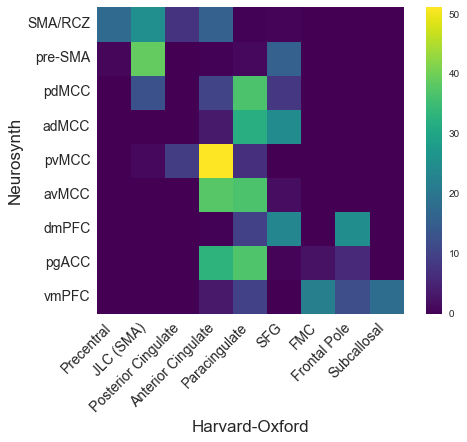

In [196]:
g = sns.heatmap(ho_results_pivot[order], 
               square=True, cmap=plt.get_cmap('viridis'))
g.set_yticklabels(g.get_yticklabels(), rotation=0, size = 14)
g.set_xticklabels(g.get_xticklabels(), rotation=45, size = 14, ha='right')
g.set_ylabel('Neurosynth', size=17)
g.set_xlabel('Harvard-Oxford', size=17)

In [227]:
neubert_order = [ 'M1',
 'CCZ','SMA',
 'RCZp',
 'Pre-SMA',
 'RCZa',
 '23ab',
 '24',
 '32d',
 '8m',
 '9m',
'FPm',
 '32pl',
 '14m',
 '11m',
 '25',
]

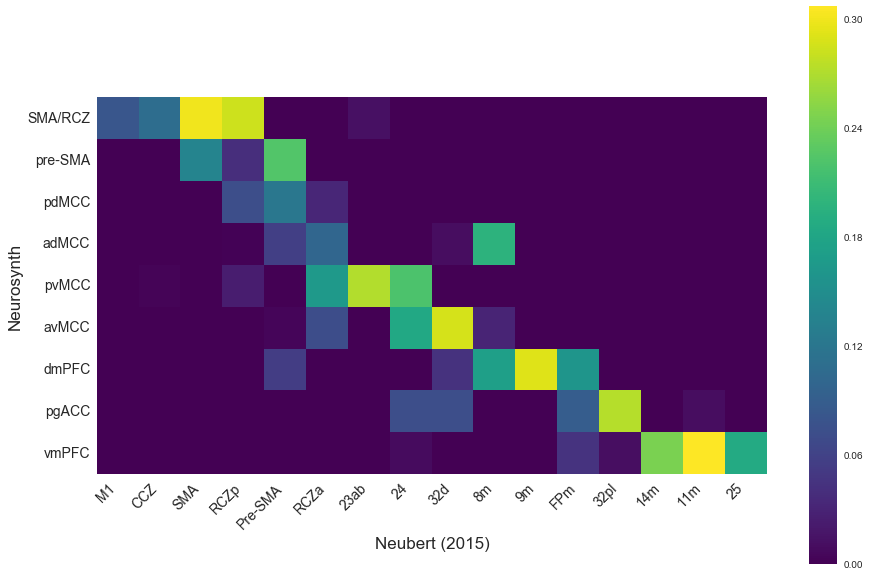

In [229]:
plt.figure(figsize=(15, 10))
g = sns.heatmap(distances[neubert_order],square=True, cmap=plt.get_cmap('viridis'))
g.set_yticklabels(g.get_yticklabels(), rotation=0, size = 14)
g.set_xticklabels(g.get_xticklabels(), rotation=45, size = 14, ha='right')
g.set_ylabel('Neurosynth', size=17)
g.set_xlabel('Neubert (2015)', size=17)

In [87]:
?g.set_xticklabels

In [133]:
ho_results_pivot

ho_label,"Cingulate Gyrus, anterior division","Cingulate Gyrus, posterior division",Frontal Medial Cortex,Frontal Orbital Cortex,Frontal Pole,Juxtapositional Lobule Cortex,Paracingulate Gyrus,Precentral Gyrus,Subcallosal Cortex,Superior Frontal Gyrus
region_name,,,,,,,,,,
SMAc,15.754232,7.492119,0.000000,0.00000,0.000000,25.388792,0.209574,17.463514,0.000000,0.570344
SMAr,0.221320,0.000000,0.000000,0.00000,0.000000,38.956345,1.083249,0.812183,0.000000,15.722843
pSMAc,10.239927,0.000000,0.000000,0.00000,0.000000,12.725275,36.893773,0.000000,0.000000,8.047619
pSMAr,3.511085,0.000000,0.000000,0.00000,0.007001,0.049008,32.123687,0.000000,0.000000,24.614936
dACCc,51.330702,9.036306,0.000000,0.00000,0.000000,1.163378,7.167324,0.035517,0.000000,0.003946
dACCr,37.731733,0.000000,0.000000,0.00000,0.000000,0.000000,36.774530,0.000000,0.000000,1.798539
dmPFC,0.227015,0.051835,0.029890,0.00000,24.905032,0.055619,9.767310,0.000378,0.000000,23.652289
rACC,33.123570,0.000000,2.241037,0.00000,5.832189,0.000000,37.170862,0.000000,0.157132,0.531655
vmPFC,3.382067,0.000000,22.050353,0.07818,12.199647,0.000000,9.734099,0.000000,18.147527,0.000000


### Gordon

In [103]:
import pickle
from neurosynth.analysis.cluster import Clusterable
import base.compare as compare
from sklearn.cluster import KMeans

In [87]:
gordon = convert_nib(nib.load('../masks/Gordon/Parcels_MNI_222.nii'))

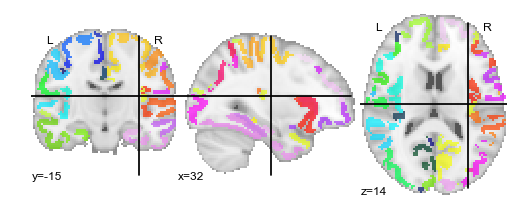

In [88]:
niplt.plot_roi(gordon)

In [89]:
saved_pca = '../results/clustering/dv_v6_reference_pca.pkl'

reference = pickle.load(open(saved_pca, 'r'))

In [102]:
roi = Clusterable(dataset, compare.binarize_nib(gordon))
distances = pairwise_distances(roi.data, reference.data, metric='correlation')

In [104]:
n_clusters = np.unique(gordon.get_data()).nonzero()[0].shape[0]
clustering_algorithm = KMeans(n_clusters = n_clusters)
clustering_algorithm.fit(distances) 

labels = clustering_algorithm.predict(distances) + 1

# Make nibabel image
header = dataset.masker.get_header()
header['cal_max'] = labels.max()
header['cal_min'] = labels.min()

ValueError: NumPy boolean array indexing assignment cannot assign 57792 input values to the 228453 output values where the mask is true

In [111]:
voxel_labels = roi.masker.unmask(labels)
ns_gordon = convert_nib(nib.nifti1.Nifti1Image(voxel_labels, gordon.get_affine(), header))

In [112]:
_, _, ns_gordon_conv = match_parcellations(gordon, ns_gordon)

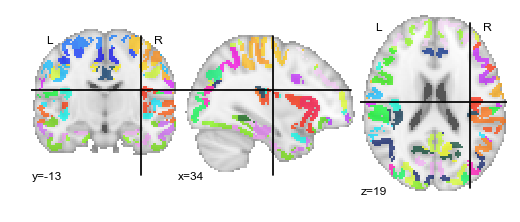

In [114]:
niplt.plot_roi(ns_gordon_conv)

In [139]:
adjusted_mutual_info_score(*compare.get_common_voxels(ns_gordon_conv, gordon))

0.72194377784393882

### Atlases

In [45]:
import nilearn.datasets as ds
from nilearn.image import resample_img

In [41]:
dataset = ds.fetch_atlas_aal()

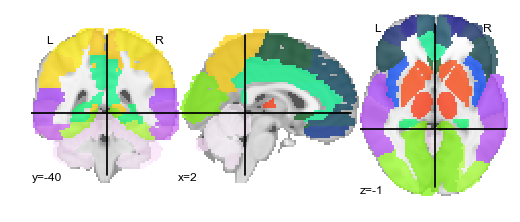

In [42]:
niplt.plot_roi(nib.load(dataset.regions))

In [55]:
match_region = nib.load(ds.fetch_atlas_aal().regions)


In [56]:
ref = nib.load('../masks/HO_ROIs/JLC.nii.gz')

In [63]:
match_region = resample_img(nib.load(ds.fetch_atlas_aal().regions), ref.get_affine(), ref.get_shape())

In [64]:
np.unique(match_region.get_data()).nonzero()[0].shape[0]

116

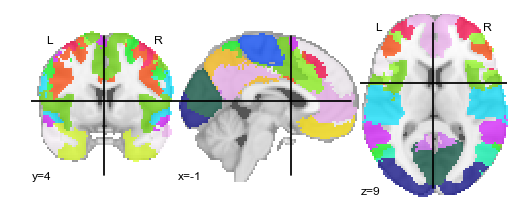

In [52]:
niplt.plot_roi(resample_img(match_region, ref.get_affine(), ref.get_shape()))